In [7]:
# Imports & stuff

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from cycler import cycler

# Constants
time = 3200
discount = 0.95
pres_sarsop = []
pres_ub = []
# all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag", "Hallway1", "Hallway2", "MiniHallway", "TigerGrid"] # All envs
all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
            "FrozenLake4", "FrozenLake10", "Tag",  "SparseHallway1", "SparseHallway2", "SparseTigerGrid"] # Messing around...
# all_envs = ["ABC", "Tiger", "RockSample5", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag",  "SparseHallway1", "SparseHallway2", "SparseTigerGrid"] # Messing around...
Env_to_latex_name = {
    "ABC" : "\\custom",
    "Tiger":"\\tiger",
    "RockSample5": "\\rocksample (5)",
    "RockSample10": "\\rocksample (10)",
    "K-out-of-N2":"\\koutofn (2)",
    "K-out-of-N3":"\\koutofn (3)",
    "FrozenLake4":"\\lake (4)",
    "FrozenLake10":"\\lake (10)",
    "Tag":"\\tagenv",
    "Hallway1":"\\hallway1",
    "Hallway2":"\\hallway2",
    "TigerGrid":"\\tigergrid",
    "SparseHallway1":"\\hallwayone",
    "SparseHallway2":"\\hallwaytwo",
    "SparseTigerGrid":"\\tigergrid",
    "MiniHallway":"\\minihallway"
}

solver_to_heuristic = {
    "SARSOP" : "FIB",
    "BIB-SARSOP" : "BIB",
    "EBIB-SARSOP" : "EBIB"
}



# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4"] #Testing envs
# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4", "FrozenLake10", "K-out-of-N3"] #Testing envs
pre_sarsop = "./Data/SarsopTest/Sarsoptest_"
pre_ub = "./Data/UpperBounds/UpperBoundTest_"
post_sarsop = f"_t{time}_d{str(discount)[2:]}.json"
post_ub =f"_d{str(discount)[2:]}.json"
for env in all_envs:
    pres_ub.append(pre_ub + env + "_")

# solvers = ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]
solvers = ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]
# solvers = ["SARSOP", "BIB-SARSOP"]

def get_data_plot(env:str):
    ts, ubs, lbs = [], [], []
    solvernames, envname = [], ""
    for s in solvers:
        filename = pre_sarsop+env+"_"+s+post_sarsop
        with open(filename) as file:
            data = json.load(file)
            ts.append(data["times"])
            ubs.append(data["ubs"])
            lbs.append(data["lbs"])
            solvernames.append(data["solver"])
            envname = data["env_full"]

    return ts, ubs, lbs, solvernames, envname

### Plotting

### Tables

In [12]:
# SARSOP Convergence test - Large

def get_vars_sarsop(data:dict):
    if data["timeout"]:
        # diff =  abs((data["final_ub"] - data["final_lw"] ) / data["final_lw"])
        diff = abs(data["final_ub"] - data["final_lw"])
        # return f' TO ({diff:.2f})'
        return f'{data["final_lw"]:.2f}, {data["final_ub"]:.2f}'
    else:
        return f'{data["runtime"]:.2f}s'


# labels = ["\\SARSOP", "\\BIBSARSOP", "\\EBIBSARSOP"]
labels = ["\\FIB", "", "\\BIB","", "\\EBIB",""]
names = []
Sarsop_lb, BibSarsop_lb, EBibSarsop_lb = [], [], []
Sarsop_ub, BibSarsop_ub, EBibSarsop_ub = [], [], []
Sarsop_its, BibSarsop_its, EBibSarsop_its = [], [], []
Sarsop_ravg, BibSarsop_ravg, EBibSarsop_ravg = [], [], []

for env in all_envs:
    pres_sarsop.append(pre_sarsop + env + "_" )
envs_sarsop = ["K-out-of-N3", "FrozenLake10","Tag","SparseHallway1", "SparseHallway2","SparseTigerGrid"]

for env in envs_sarsop:
    thispre = pre_sarsop + env + "_"
    filename_Sarsop = thispre + "SARSOP" + post_sarsop
    # print(pre)
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        # names.append(this_data["env_full"])
        names.append(Env_to_latex_name[this_data["env"]])
        Sarsop_lb.append(f'{this_data["final_lw"]:.2f}')
        Sarsop_ub.append(f'{this_data["final_ub"]:.2f}')
        Sarsop_its.append(len(this_data["times"]))
        Sarsop_ravg.append(f'{this_data["sim_r"]:.2f}')
        # print("Sarsop: ", len(this_data["times"]))

    filename_BibSarsop = thispre + "BIB-SARSOP" + post_sarsop
    with open(filename_BibSarsop) as file:
        this_data = json.load(file)
        BibSarsop_lb.append(f'{this_data["final_lw"]:.2f}')
        BibSarsop_ub.append(f'{this_data["final_ub"]:.2f}')
        BibSarsop_its.append(len(this_data["times"]))
        BibSarsop_ravg.append(f'{this_data["sim_r"]:.2f}')
        # print("BIBSarsop: ", len(this_data["times"]))

    filename_EBibSarsop = thispre + "EBIB-SARSOP" + post_sarsop
    with open(filename_EBibSarsop) as file:
        this_data = json.load(file)
        EBibSarsop_lb.append(f'{this_data["final_lw"]:.2f}')
        EBibSarsop_ub.append(f'{this_data["final_ub"]:.2f}')
        EBibSarsop_its.append(len(this_data["times"]))
        EBibSarsop_ravg.append(f'{this_data["sim_r"]:.2f}')
        # print("BIBSarsop: ", len(this_data["times"]))

dataframe = pd.DataFrame([Sarsop_lb, Sarsop_ub, BibSarsop_lb, BibSarsop_ub,EBibSarsop_lb, EBibSarsop_ub,], index=labels, columns=names).transpose()

# dataframe = pd.DataFrame([Sarsop_ravg, BibSarsop_ravg, EBibSarsop_ravg], index=labels, columns=names).transpose()


print(dataframe)

print(dataframe.to_latex(column_format="l||cc|cc|cc"))

                \FIB           \BIB          \EBIB       
\koutofn (3)   -2.63  -2.12   -2.63  -2.36   -2.63  -2.36
\lake (10)      0.06   0.11    0.06   0.09    0.06   0.09
\tagenv       -10.83  -6.59  -10.86  -6.94  -10.87  -6.94
\hallwayone     1.34   1.56    1.33   1.49    1.33   1.48
\hallwaytwo     0.38   0.83    0.39   0.77    0.38   0.77
\tigergrid      2.28   2.53    2.28   2.46    2.27   2.45
\begin{tabular}{l||cc|cc|cc}
\toprule
 & \FIB &  & \BIB &  & \EBIB &  \\
\midrule
\koutofn (3) & -2.63 & -2.12 & -2.63 & -2.36 & -2.63 & -2.36 \\
\lake (10) & 0.06 & 0.11 & 0.06 & 0.09 & 0.06 & 0.09 \\
\tagenv & -10.83 & -6.59 & -10.86 & -6.94 & -10.87 & -6.94 \\
\hallwayone & 1.34 & 1.56 & 1.33 & 1.49 & 1.33 & 1.48 \\
\hallwaytwo & 0.38 & 0.83 & 0.39 & 0.77 & 0.38 & 0.77 \\
\tigergrid & 2.28 & 2.53 & 2.28 & 2.46 & 2.27 & 2.45 \\
\bottomrule
\end{tabular}



In [21]:
# SARSOP Convergence test - Small

def get_vars_sarsop(data:dict):
    if data["timeout"]:
        # diff =  abs((data["final_ub"] - data["final_lw"] ) / data["final_lw"])
        diff = abs(data["final_ub"] - data["final_lw"])
        return f' {diff:.2f}'
        # return f'{data["final_lw"]:.2f}, {data["final_ub"]:.2f}'
    else:
        return f'{data["runtime"]:.2f}s'


# labels = ["\\SARSOP", "\\BIBSARSOP", "\\EBIBSARSOP"]
labels = ["\\FIB",  "\\BIB", "\\EBIB"]
names = []
Sarsop_lb, BibSarsop_lb, EBibSarsop_lb = [], [], []
Sarsop_ub, BibSarsop_ub, EBibSarsop_ub = [], [], []
Sarsop_its, BibSarsop_its, EBibSarsop_its = [], [], []
Sarsop_times, BibSarsop_times, EBibSarsop_times = [], [], []
Sarsop_data, BibSarsop_data, EBibSarsop_data = [], [], []

for env in all_envs:
    pres_sarsop.append(pre_sarsop + env + "_" )
envs_sarsop = ["ABC","Tiger", "RockSample5", "FrozenLake4",  "K-out-of-N2",
               "RockSample10","FrozenLake10", "K-out-of-N3","Tag", "SparseHallway1", "SparseHallway2","SparseTigerGrid"]

for env in envs_sarsop:
    thispre = pre_sarsop + env + "_"
    filename_Sarsop = thispre + "SARSOP" + post_sarsop
    # print(pre)
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        # names.append(this_data["env_full"])
        names.append(Env_to_latex_name[this_data["env"]])
        Sarsop_lb.append(f'{this_data["final_lw"]:.2f}')
        Sarsop_ub.append(f'{this_data["final_ub"]:.2f}')
        Sarsop_its.append(len(this_data["times"]))
        Sarsop_times.append(f'{this_data["runtime"]:.2f}')
        Sarsop_data.append(get_vars_sarsop(this_data))
        # print("Sarsop: ", len(this_data["times"]))

    filename_BibSarsop = thispre + "BIB-SARSOP" + post_sarsop
    with open(filename_BibSarsop) as file:
        this_data = json.load(file)
        BibSarsop_lb.append(f'{this_data["final_lw"]:.2f}')
        BibSarsop_ub.append(f'{this_data["final_ub"]:.2f}')
        BibSarsop_its.append(len(this_data["times"]))
        BibSarsop_times.append(f'{this_data["runtime"]:.2f}')
        BibSarsop_data.append(get_vars_sarsop(this_data))
        # print("BIBSarsop: ", len(this_data["times"]))

    filename_EBibSarsop = thispre + "EBIB-SARSOP" + post_sarsop
    with open(filename_EBibSarsop) as file:
        this_data = json.load(file)
        EBibSarsop_lb.append(f'{this_data["final_lw"]:.2f}')
        EBibSarsop_ub.append(f'{this_data["final_ub"]:.2f}')
        EBibSarsop_its.append(len(this_data["times"]))
        EBibSarsop_times.append(f'{this_data["runtime"]:.2f}')
        EBibSarsop_data.append(get_vars_sarsop(this_data))
        # print("BIBSarsop: ", len(this_data["times"]))

# dataframe = pd.DataFrame([Sarsop_lb, Sarsop_ub, BibSarsop_lb, BibSarsop_ub,EBibSarsop_lb, EBibSarsop_ub,], index=labels, columns=names).transpose()

# dataframe = pd.DataFrame([Sarsop_times, BibSarsop_times, EBibSarsop_times], index=labels, columns=names).transpose()

dataframe = pd.DataFrame([Sarsop_data, BibSarsop_data, EBibSarsop_data], index=labels, columns=names).transpose()


print(dataframe)

print(dataframe.to_latex(column_format="l||c|c|c"))

                     \FIB    \BIB   \EBIB
\custom             0.32s   0.72s   9.95s
\tiger              0.46s   1.13s   8.70s
\rocksample (5)     0.98s   2.61s  11.09s
\lake (4)           0.55s   0.82s  12.58s
\koutofn (2)      412.46s  57.65s  61.26s
\rocksample (10)     0.29    0.30    0.29
\lake (10)           0.05    0.03    0.03
\koutofn (3)         0.52    0.27    0.27
\tagenv              4.24    3.93    3.93
\hallwayone          0.22    0.15    0.15
\hallwaytwo          0.45    0.38    0.39
\tigergrid           0.25    0.18    0.18
\begin{tabular}{l||c|c|c}
\toprule
 & \FIB & \BIB & \EBIB \\
\midrule
\custom & 0.32s & 0.72s & 9.95s \\
\tiger & 0.46s & 1.13s & 8.70s \\
\rocksample (5) & 0.98s & 2.61s & 11.09s \\
\lake (4) & 0.55s & 0.82s & 12.58s \\
\koutofn (2) & 412.46s & 57.65s & 61.26s \\
\rocksample (10) &  0.29 &  0.30 &  0.29 \\
\lake (10) &  0.05 &  0.03 &  0.03 \\
\koutofn (3) &  0.52 &  0.27 &  0.27 \\
\tagenv &  4.24 &  3.93 &  3.93 \\
\hallwayone &  0.22 &  0.15 &  0

In [14]:
# Upper bounds

def get_vars_ub(data:dict):
    if data["solver"] == "SARSOP":
        # return f'{data["ub"]:.2f}, ({data["solvetime"]:.1f}s)'
        if data["solvetime"] < 60:
            return f'{data["ub"]:.2f}'
        else:
            return f'{data["ub"]:.2f}'
    else:
        if data["solvetime"] > 1200:
            return "TO"
        else:
            t = f'{data["solvetime"]:.1f}s'
        return f'{data["ub"]:.2f} ({t})'

heuristic_names = ["FIB", "BIB", "EBIB", "WBIB", "SARSOP"]
labels = ["$|\\states|$", "$|\\actions|$", "$|\\observations|$", "$|\\Bsao|$",  "$|\\Bbao|$",   "\\FIB", "", "\\BIB","", "\\EBIB","", "\\OBIB","", "\\SARSOP"]
# heuristic_names = ["FIB", "BIB", "EBIB", "SARSOP"]
# labels = ["\\FIB", "\\BIB", "\\EBIB", "\\SARSOP"]
env_names, S, A, O, Bsao, Bbao = [], [], [], [], [], []
bounds = []
times = []
for _h in heuristic_names:
    bounds.append([])
    times.append([])
for _e in pres_ub:
    env_names.append("")
    S.append(""); A.append("");O.append("")
    Bsao.append(""); Bbao.append("")

for (heur_idx, name) in enumerate(heuristic_names):
    for (env_idx, thispre) in enumerate(pres_ub):
        
        filename = thispre + name + post_ub
        with open(filename) as file:
            this_data = json.load(file)
            env_names[env_idx] = Env_to_latex_name[this_data["env"]]
            S[env_idx] = this_data["env_data"]["ns"]
            A[env_idx] = this_data["env_data"]["na"]
            O[env_idx] = this_data["env_data"]["no"]
            Bsao[env_idx] = this_data["env_data"]["nb"]
            Bbao[env_idx] = this_data["env_data"]["nbao"]

            bounds[heur_idx].append(f'{this_data["ub"]:.2f}')
            if this_data["solvetime"] < 1200:
                times[heur_idx].append(f'{this_data["solvetime"]:.2f}s')
            else:
                times[heur_idx].append("TO")

print(bounds)
print(env_names)
print(labels)

data = [S, A, O, Bsao, Bbao, bounds[0], times[0], bounds[1], times[1], bounds[2], times[2],bounds[3], times[3],bounds[4]]

print(data)

dataframe = pd.DataFrame( data, index=labels, columns=env_names).transpose()

print(dataframe)

print(dataframe.to_latex(column_format="l||ccccc||cc|cc|cc|cc|c"))




[['0.72', '87.20', '18.34', '16.46', '-1.24', '-1.88', '0.41', '0.16', '-4.75', '1.58', '0.82', '2.73'], ['0.58', '49.63', '18.34', '16.44', '-1.52', '-2.28', '0.39', '0.13', '-5.58', '1.49', '0.77', '2.58'], ['0.48', '40.53', '18.34', '16.44', '-1.52', '-2.28', '0.39', '0.13', '-5.57', '1.48', '0.77', '2.57'], ['0.48', '40.53', '18.34', '16.44', '-1.52', '-1.99', '0.39', '0.11', '-5.53', '1.56', '0.82', '2.67'], ['0.47', '19.55', '17.09', '14.21', '-1.73', '-2.10', '0.39', '0.11', '-6.38', '1.56', '0.83', '2.53']]
['\\custom', '\\tiger', '\\rocksample (5)', '\\rocksample (10)', '\\koutofn (2)', '\\koutofn (3)', '\\lake (4)', '\\lake (10)', '\\tagenv', '\\hallwayone', '\\hallwaytwo', '\\tigergrid']
['$|\\states|$', '$|\\actions|$', '$|\\observations|$', '$|\\Bsao|$', '$|\\Bbao|$', '\\FIB', '', '\\BIB', '', '\\EBIB', '', '\\OBIB', '', '\\SARSOP']
[[6, 2, 201, 1601, 16, 64, 17, 101, 842, 60, 92, 36], [3, 3, 8, 9, 9, 27, 6, 6, 5, 5, 5, 5], [1, 2, 3, 3, 16, 64, 17, 101, 30, 21, 17, 17], [1

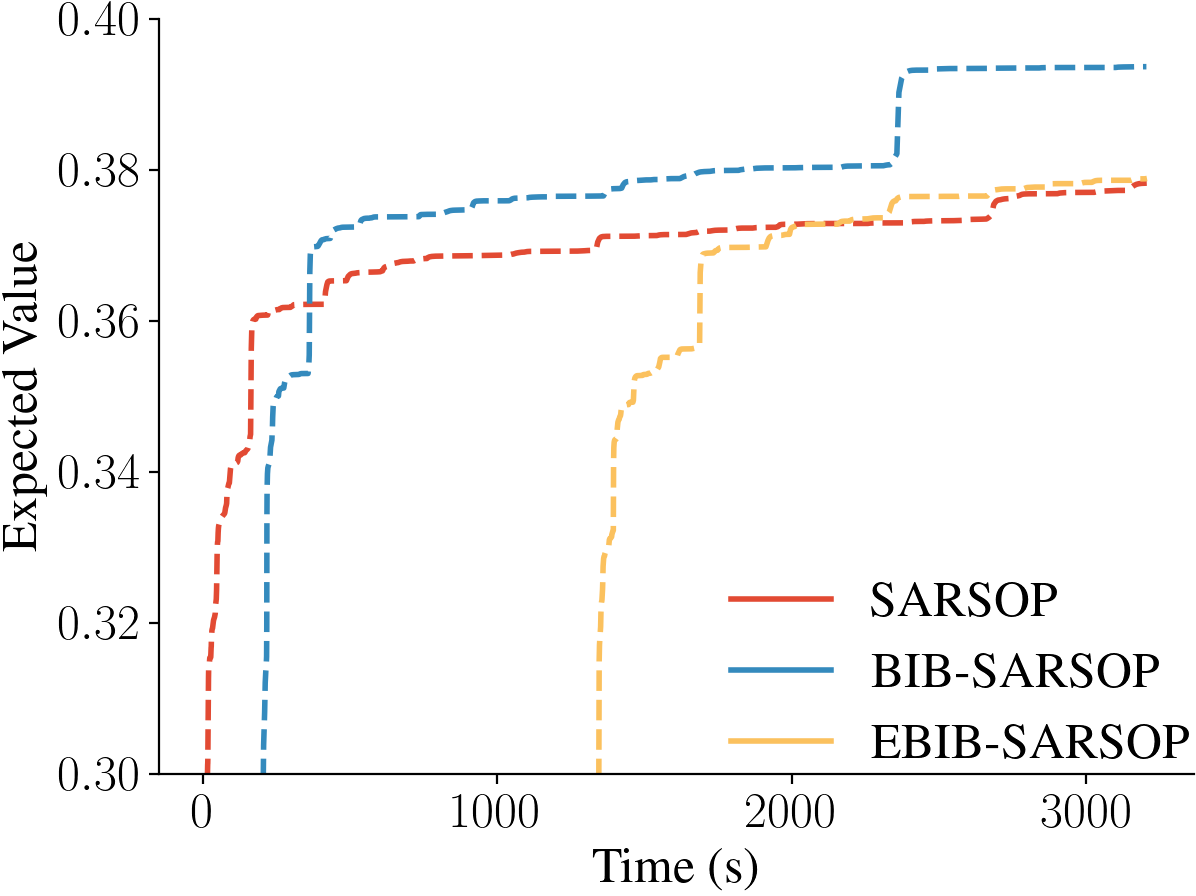

In [ ]:
colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']
interesting = ["SparseHallway2"]


ts, ubs, lbs, solvernames, envname = get_data_plot("SparseHallway2")

for (i,label) in enumerate(solvernames):
    plt.plot(ts[i][1:],ubs[i][1:], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i][1:],lbs[i][1:], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Expected Value")

plt.ylim(0.3, 0.4)
# plt.xlim(0,1000)
plt.legend()
plt.show()

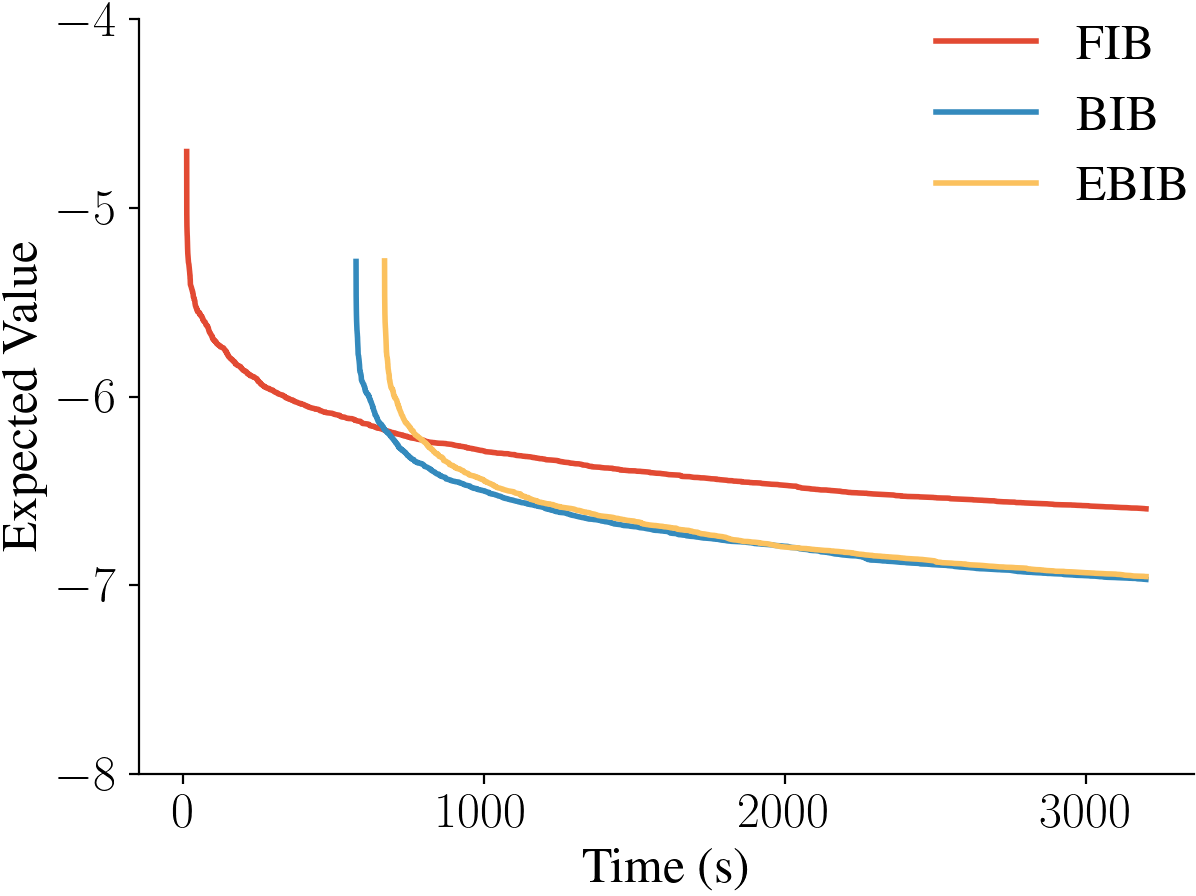

In [ ]:
colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']

# K-out-of-N2

ts, ubs, lbs, solvernames, envname = get_data_plot("Tag")

for (i,solver) in enumerate(solvernames):
    label = solver_to_heuristic[solver]
    plt.plot(ts[i][1:],ubs[i][1:], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i][1:],lbs[i][1:], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Expected Value")

plt.ylim(-8, -4)
plt.legend()
plt.show()


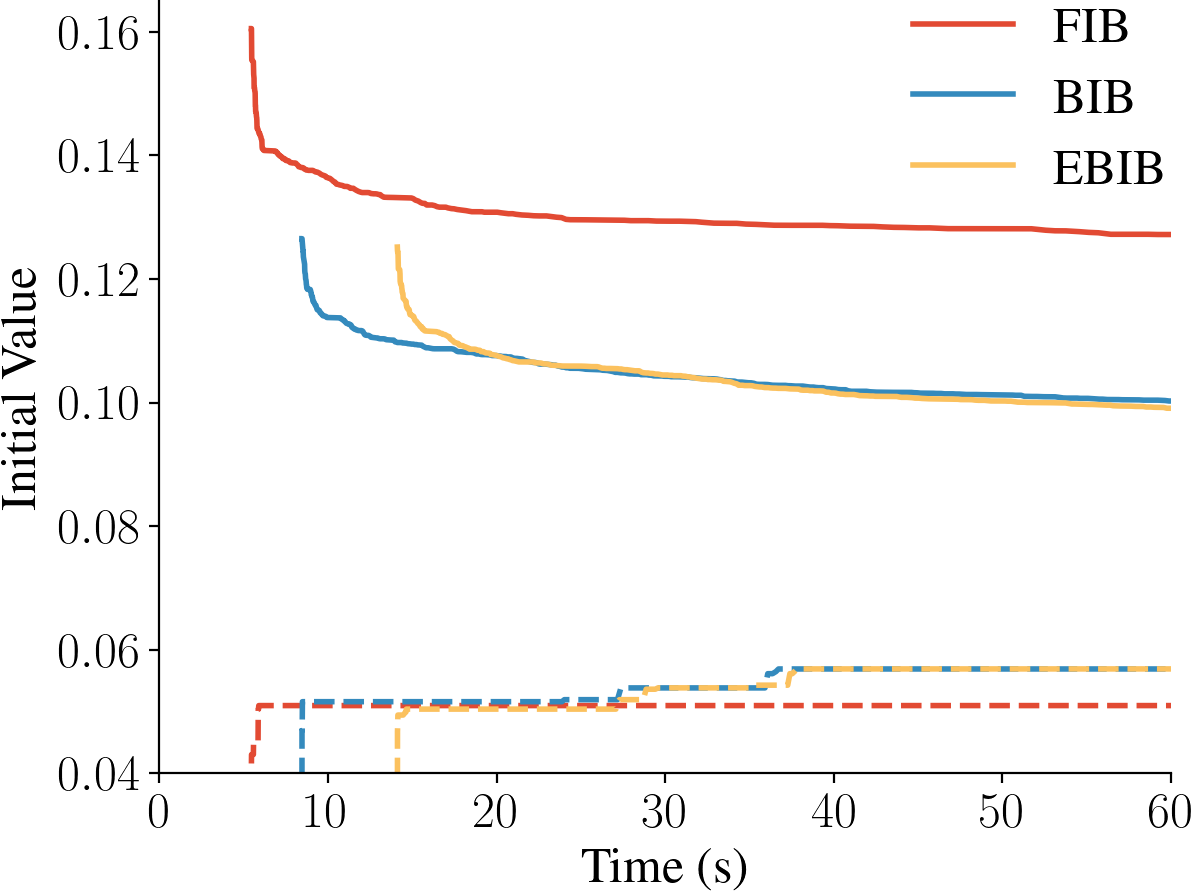

In [ ]:
# K-out-of-N2

filename = "Data/Figures/SarsopTest_FrozenLake10.pdf"
ts, ubs, lbs, solvernames, envname = get_data_plot("FrozenLake10")

for (i,solver) in enumerate(solvernames):
    label = solver_to_heuristic[solver]
    # label = solver
    plt.plot(ts[i][1:],ubs[i][1:], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i][1:],lbs[i][1:], label=None, color=colours[i], linestyle="--")
    # x,y  = ts[i][-1], (ubs[i][-1] + lbs[i][-1])/2
    # plt.plot(x,y, marker="o", markersize=15, label=None, color=colours[i])
    # x,y  = ts[i][-1], lbs[i][-1]
    # plt.plot(x,y, marker="X", markersize=10, label=None, color=colours[i])

plt.xlabel("Time (s)")
plt.ylabel("Initial Value")

plt.ylim(0.04, 0.165)
plt.xlim(0, 60)
plt.legend()
plt.savefig(filename, transparent=True)
plt.show()
